# CellRank 

Messages from 16/12/2021. To make sure we are talking about the same dataset I've regenerated and saved the subset
from `03_subclustering.Rdm`. I will now combine RNA-velocity estimation for each cell and run CellRank.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv

from natsort import natsorted
from matplotlib import rcParams

random_seed = 12345
np.random.seed(random_seed)
sc.settings.set_figure_params(dpi=80)

scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.settings.set_figure_params('scvelo')  # for beautified visualization

rcParams['figure.figsize'] = 7, 7

In [2]:
velocity = sc.read("../data/processed/04_scvelo.h5ad")

In [3]:
adata = sc.read("../data/processed/03_subcluster.h5ad")

## Merge velocity

In [4]:
common_genes = np.intersect1d(adata.var_names, velocity.var_names)
adata = adata[:, common_genes]
velocity = velocity[adata.obs_names, common_genes]

adata.layers['ambiguous'] = velocity.layers['ambiguous']
adata.layers['spliced'] = velocity.layers['spliced']
adata.layers['unspliced'] = velocity.layers['unspliced']

In [5]:
adata

AnnData object with n_obs × n_vars = 1805 × 25908
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'RNA_snn_res.0.8', 'seurat_clusters', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'RNA_snn_res.1'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'ambiguous', 'spliced', 'unspliced'
    obsp: 'distances'

In [6]:
adata.obs.seurat_clusters = adata.obs.seurat_clusters.astype('category')

... storing 'Phase' as categorical
... storing 'HTO_maxID' as categorical
... storing 'HTO_secondID' as categorical
... storing 'HTO_classification' as categorical
... storing 'HTO_classification.global' as categorical


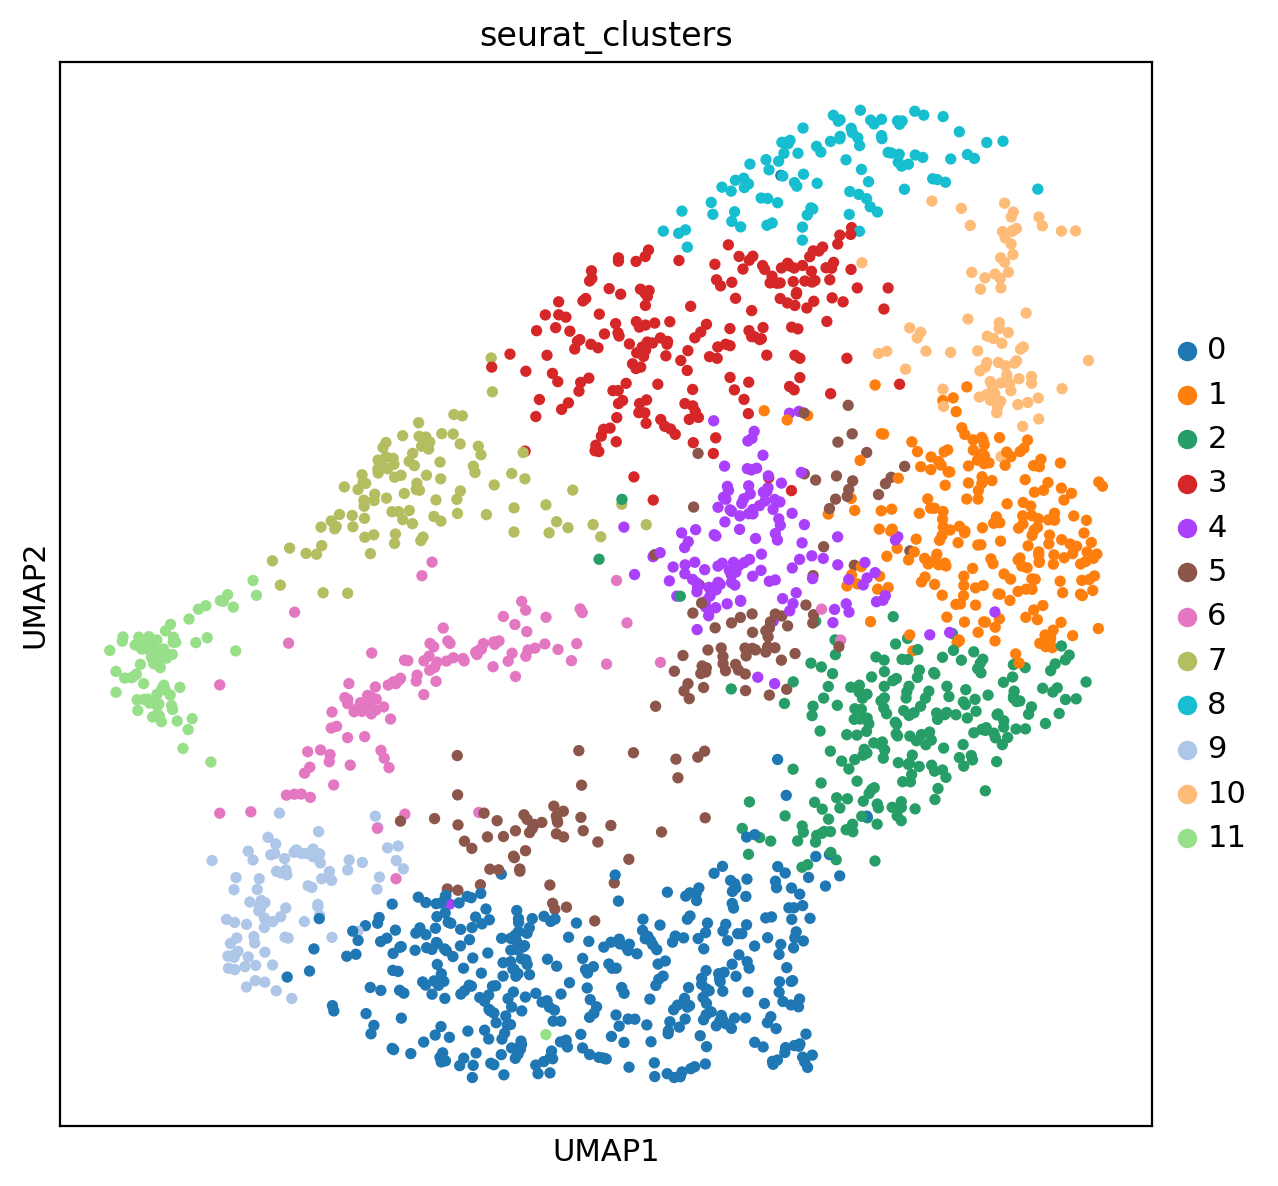

In [7]:
sc.pl.umap(adata, color=['seurat_clusters'])

## Run velocity

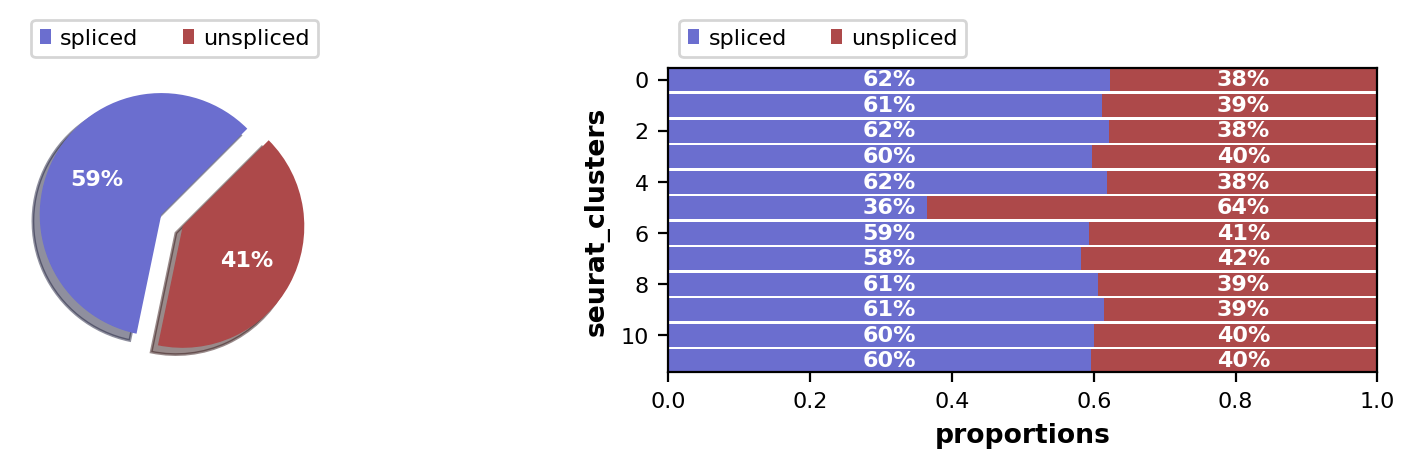

In [8]:
scv.pl.proportions(adata, groupby="seurat_clusters")

In [9]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2_000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 13986 genes that are detected 20 counts (shared).
Normalized count data: spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:06) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [10]:
scv.tl.recover_dynamics(adata, n_jobs=30)

recovering dynamics (using 30/224 cores)


  0%|          | 0/1440 [00:00<?, ?gene/s]

    finished (0:08:17) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [11]:
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/224 cores)


  0%|          | 0/1805 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [12]:
# adata.write("../data/processed/06_adata_velo.h5ad", compression="gzip")

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


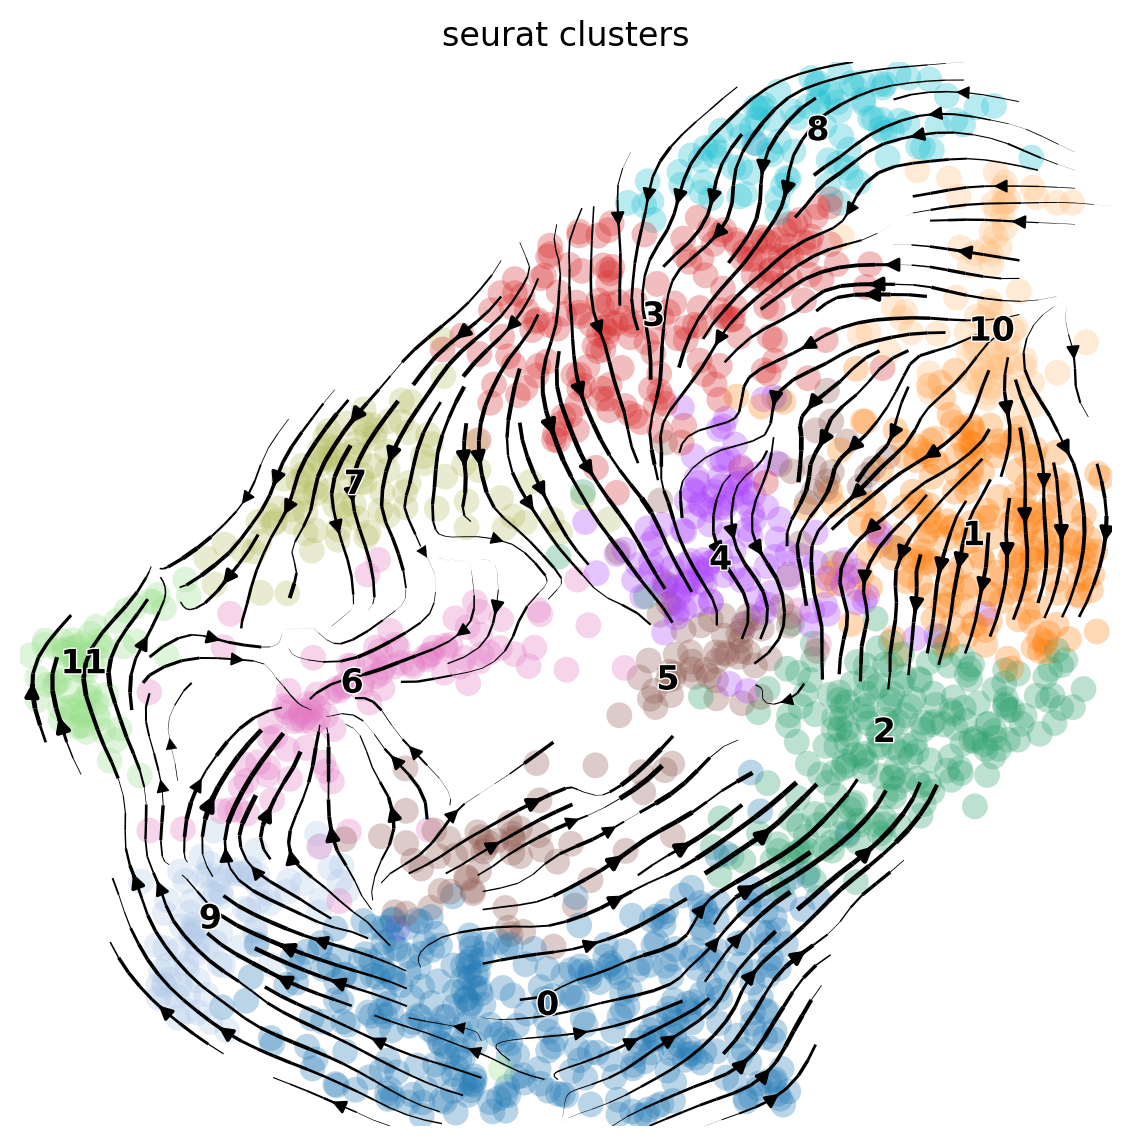

In [13]:
scv.pl.velocity_embedding_stream(adata, basis="umap", color=['seurat_clusters'])

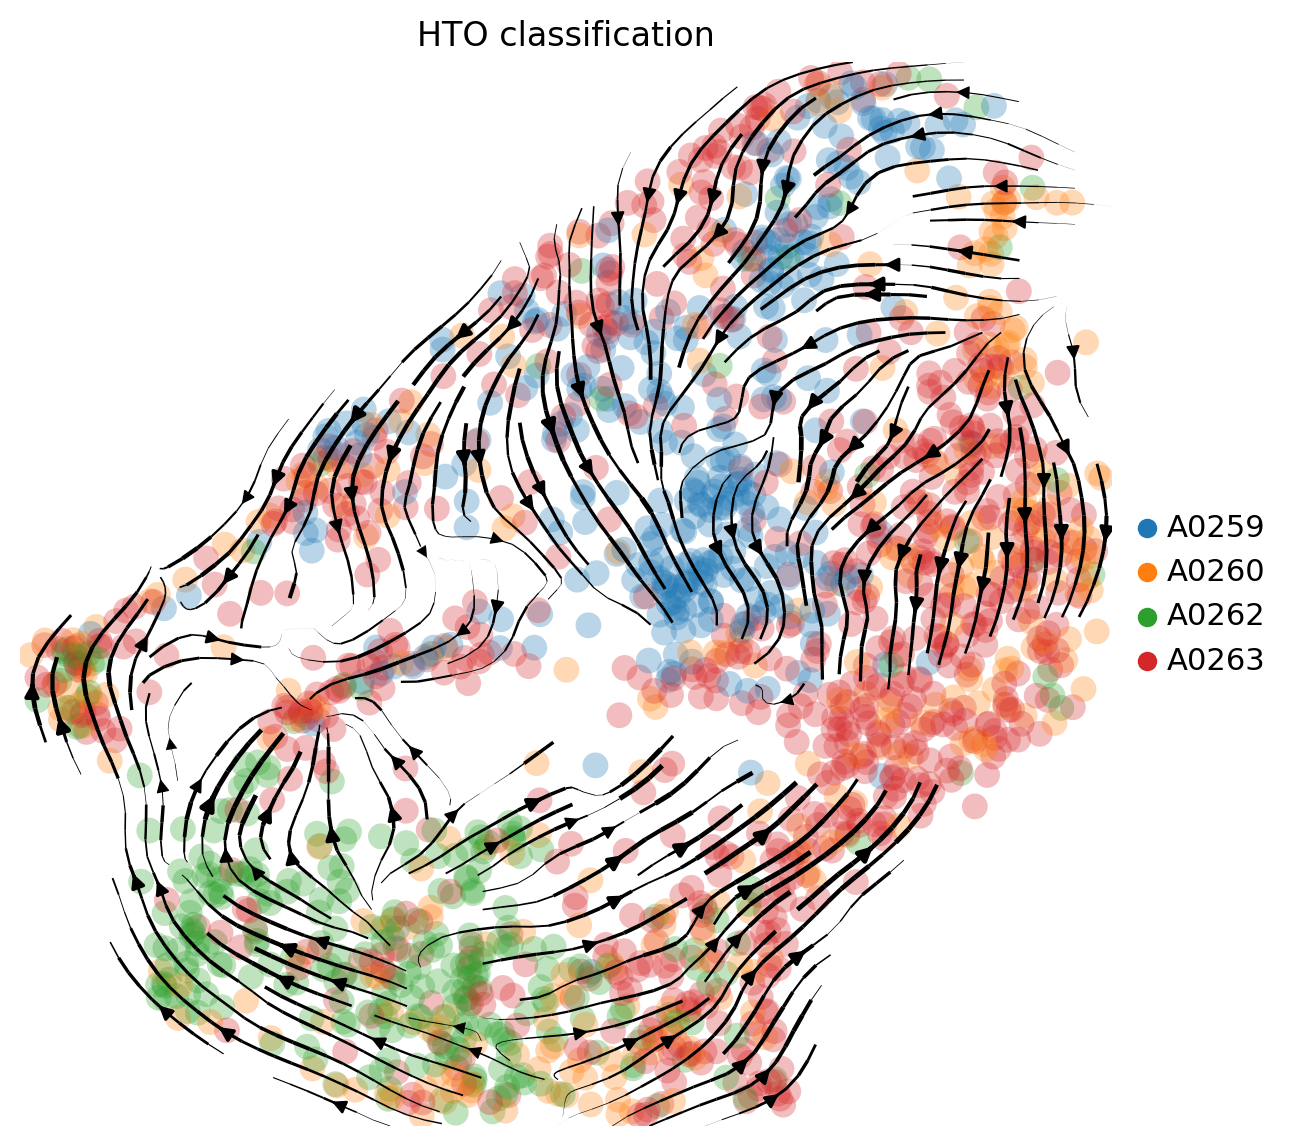

In [14]:
scv.pl.velocity_embedding_stream(adata, basis="umap", color=['HTO_classification'], legend_loc='right')

## Latent time

computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


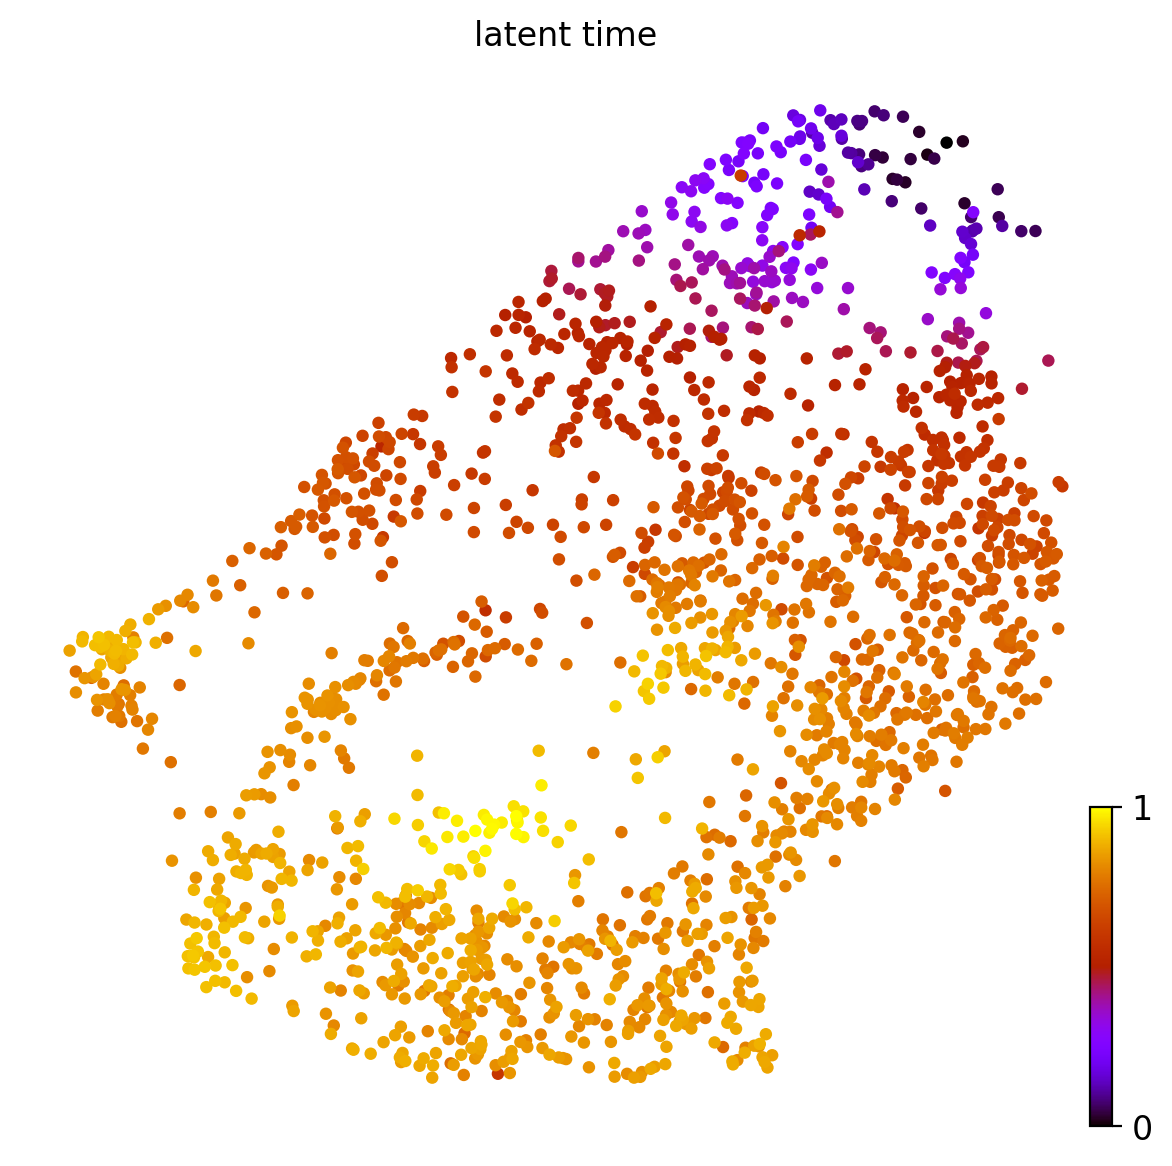

In [17]:
scv.tl.latent_time(adata)
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=80)

### Top 15 driver genes

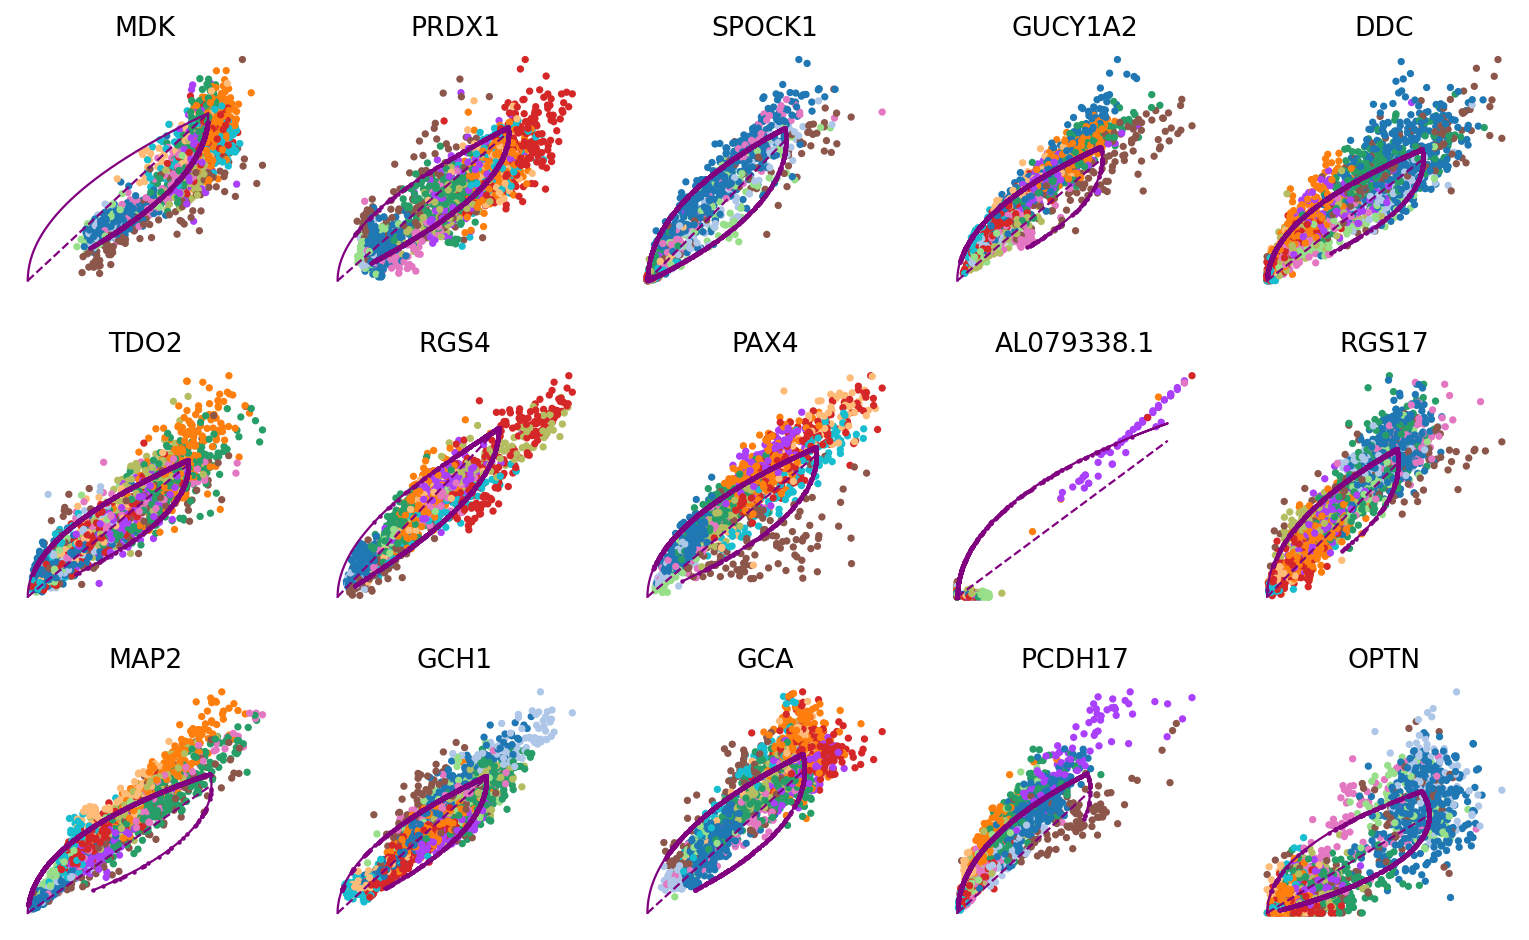

In [21]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index
scv.pl.scatter(adata, basis=top_genes[:15], ncols=5, frameon=False, color='seurat_clusters')

### Cluster-specific driver genes

In [25]:
scv.tl.rank_dynamical_genes(adata, groupby='seurat_clusters')
df = scv.get_df(adata, 'rank_dynamical_genes/names')
df.to_csv("../results/06_cluster_drivers.csv")
df.head(20)

ranking genes by cluster-specific likelihoods
    finished (0:00:01) --> added 
    'rank_dynamical_genes', sorted scores by group ids (adata.uns)


0           1        2          3        4        5         6  \
0       MDK       PRDX1      MDK        MDK      MDK     RGS4       MDK   
1     NRXN1         MDK     PAX4       MAP2    PRDX1   ANTXR2     PRDX1   
2     RGS17       CSMD3    NRXN1    GUCY1A2  GUCY1A2    TGFB2     YPEL1   
3      PAX4     GUCY1A2     SIK2      LIN7A    YPEL1   KLHL35      GCH1   
4       KIZ        PAX4    GFRA1      TLCD4      GCA     TDO2  TNFRSF21   
5       FEV        SIK2   TMEFF1      RPS13     GCH1     SCGN      AIF1   
6    SPOCK1         DDC      DDC    HTATSF1    RGS17    TTC29     H2AFJ   
7    PRKAG2       YPEL1     GCH1      THSD4     PAX4    YPEL1     MYO10   
8    PCDH17       GFRA1    PRDX1    DYNC2H1    CSMD3     LDB2      RGS4   
9    OR51E1  ST6GALNAC5     RGS4      PEX5L     RGS4     MAP2      PAX4   
10     SCGN       NRXN1    YPEL1       TDO2     TDO2    ESRRG      TDO2   
11    LIN7A     OLFML2B  GUCY1A2      MYO10    GFRA1  SLITRK2       AK5   
12    ALCAM      TMEFF1    CELF4      CRIM1   TMEFF1     GCH1    SPOCK1   
13    PEX5L     HTATSF1     NAV3     KLHL35      DDC      AHR     S100Z   
14     OPTN       ESRRG      GCA       CBLB     SIK2  RAPGEF5    IGFBP5   
15  HTATSF1        RGS4    PRKCH      S100Z     DPP6   PLCXD3     PCSK2   
16    PRKCH       CELF4  ADAMTS9  LINC00242    PRDM8   LRRTM1   HTATSF1   
17   TMEFF1        DPP6   SHISA9      CSMD3    PEX5L    ACAT2  TMEM132D   
18     GRM8        CBLB     MAP2   BAIAP2L2     RGS5    RPS13       GCA   
19     CNN3       PRDM8    H2AFJ        ARX    ROBO2  C9orf16    HMGCS1   

          7           8        9          10        11  
0       MDK       PRDX1      MDK     GUCY1A2     H2AFJ  
1     PRDX1        MAP2    RGS17       CSMD3       DDC  
2      MAP2        RGS4      KIZ       PRDX1       MDK  
3     GFRA1  ST6GALNAC5    NRXN1        MAP2  TNFRSF21  
4     LIN7A       CLCA1     PRM1       MYO10      GCH1  
5      GCH1         KIZ      DDC     OLFML2B    TMEFF1  
6   HTATSF1      OR51E1    H2AFJ       DCDC1      SIK2  
7     PEX5L        PAX4    KLHL1  ST6GALNAC5     RGS17  
8      TDO2     TMEM108    ESRRG     TMEM108      OPTN  
9    OR51E1      CASP10      FEV       LIN7A     NFKB1  
10     SCGN       S100Z   SPOCK1        TDO2    HMGCS1  
11     PAX4     RETREG1  HTATSF1        NAV3    SPOCK1  
12   IGFBP5     FAM107B  DYNC2H1     HTATSF1      AIF1  
13   SNHG18    TNFRSF21   ANKS1B       PEX5L      PSD3  
14   TMEFF1         GCA    ALCAM        DPP6      FUT8  
15      GCA       MYO10     SCGN         GCA   RAPGEF5  
16    RPS13        GCLM    ERO1B       NEGR1     THSD4  
17     LDB2        IDI1     PDK3     ADAMTS9   ADAMTS6  
18    PRDM8       MYOCD  FAM155A        RGS4      DLK1  
19    YPEL1     C9orf16    THSD4      OR51E1   FAM107B

## CellRank

In [26]:
import cellrank as cr

In [27]:
cr.tl.terminal_states(
    adata,
    cluster_key="seurat_clusters",
    weight_connectivities=0.2,
    n_states=4,
#     softmax_scale=4,
)

/projects/dan1/people/fdb589/envs/cellrank-1.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `cellrank.tl.terminal_states` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  """
/projects/dan1/people/fdb589/envs/cellrank-1.3.1/lib/python3.7/site-packages/cellrank/tl/_init_term_states.py:161: DeprecationWarning: `cellrank.tl.transition_matrix` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  **kwargs,


  0%|          | 0/1805 [00:00<?, ?cell/s]

  0%|          | 0/1805 [00:00<?, ?cell/s]

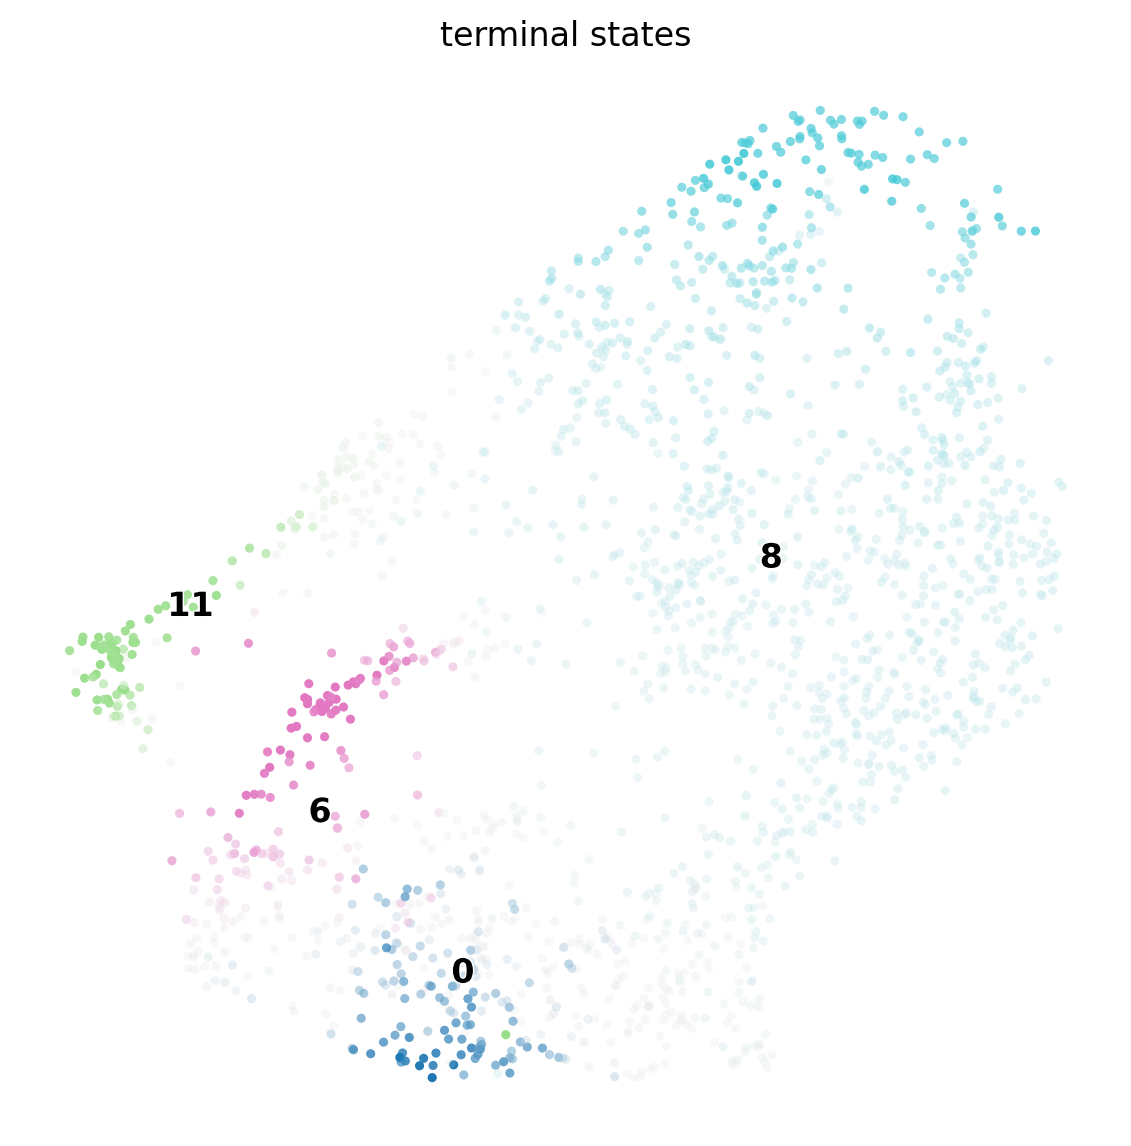

In [28]:
cr.pl.terminal_states(adata)

/projects/dan1/people/fdb589/envs/cellrank-1.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `cellrank.tl.initial_states` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  """Entry point for launching an IPython kernel.
/projects/dan1/people/fdb589/envs/cellrank-1.3.1/lib/python3.7/site-packages/cellrank/tl/_init_term_states.py:161: DeprecationWarning: `cellrank.tl.transition_matrix` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  **kwargs,


  0%|          | 0/1805 [00:00<?, ?cell/s]

  0%|          | 0/1805 [00:00<?, ?cell/s]

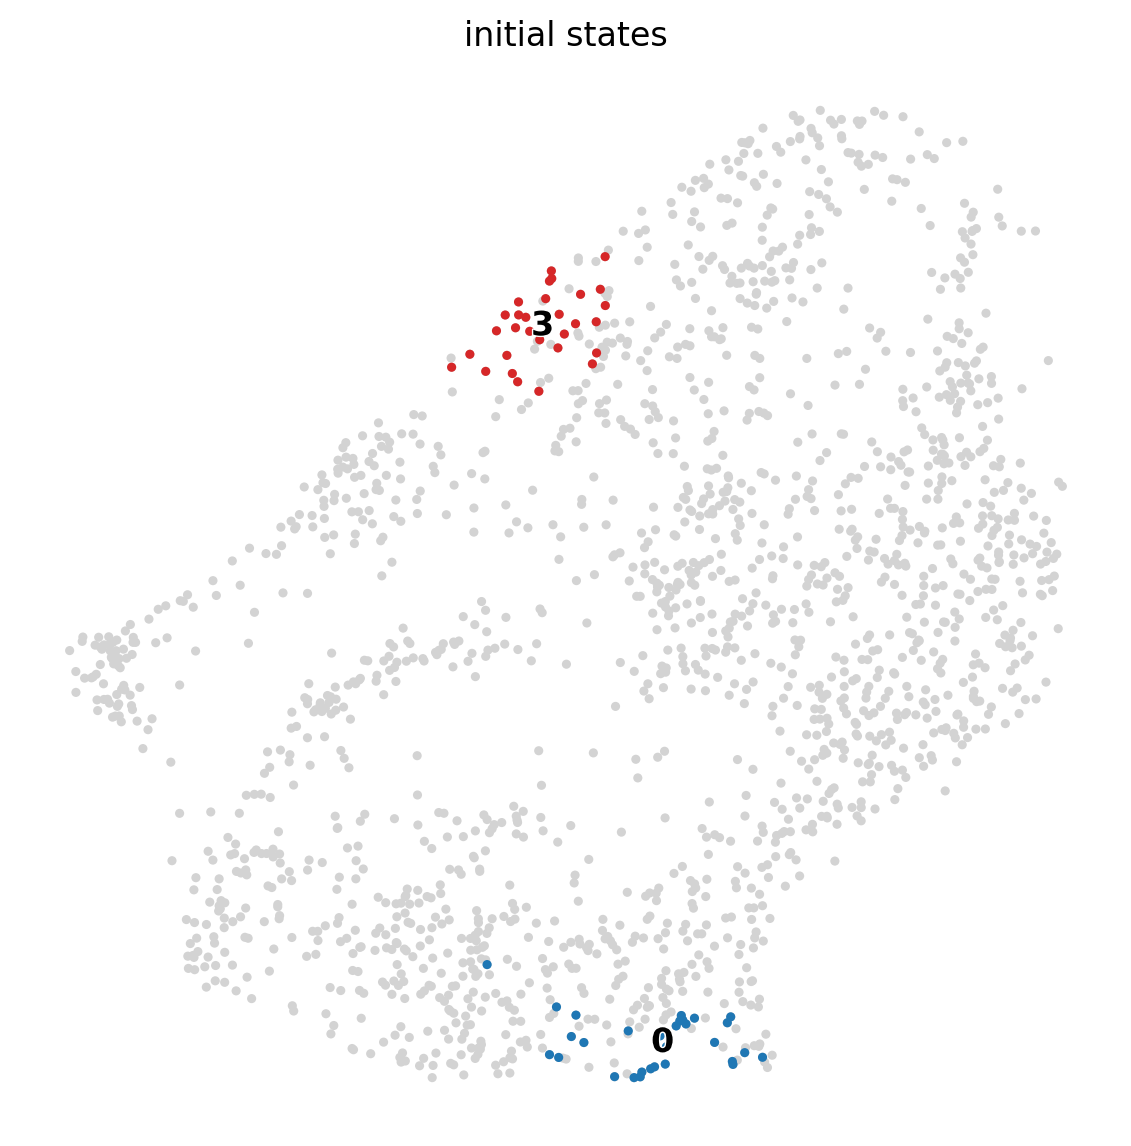

In [29]:
cr.tl.initial_states(adata, cluster_key="seurat_clusters")
cr.pl.initial_states(adata, discrete=True)

### Cell fate

Calculate the probability for each cell ending up in the terminal state (clusters: 11, 6, 0 and 8).

/projects/dan1/people/fdb589/envs/cellrank-1.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `cellrank.tl.lineages` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  """Entry point for launching an IPython kernel.


  0%|          | 0/4 [00:00<?, ?/s]

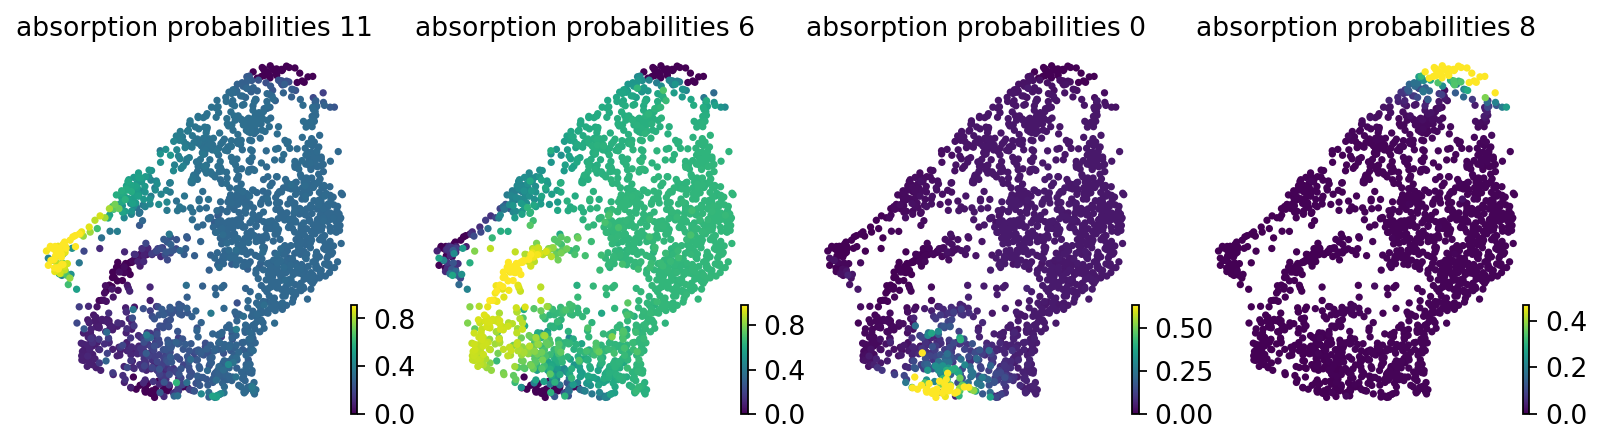

In [31]:
cr.tl.lineages(adata)
cr.pl.lineages(adata, same_plot=False)

### PAGA

In [33]:
scv.tl.recover_latent_time(
    adata, root_key="initial_states_probs", end_key="terminal_states_probs"
)

computing latent time using initial_states_probs, terminal_states_probs as prior
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)


In [34]:
scv.tl.paga(
    adata,
    groups="seurat_clusters",
    root_key="initial_states_probs",
    end_key="terminal_states_probs",
    use_time_prior="velocity_pseudotime",
)

running PAGA using priors: ['velocity_pseudotime', 'initial_states_probs', 'terminal_states_probs']
    finished (0:00:00) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


/projects/dan1/people/fdb589/envs/cellrank-1.3.1/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: Passing *transOffset* without *offsets* has no effect. This behavior is deprecated since 3.5 and in 3.6, *transOffset* will begin having an effect regardless of *offsets*. In the meantime, if you wish to set *transOffset*, call collection.set_offset_transform(transOffset) explicitly.
  alpha=alpha,


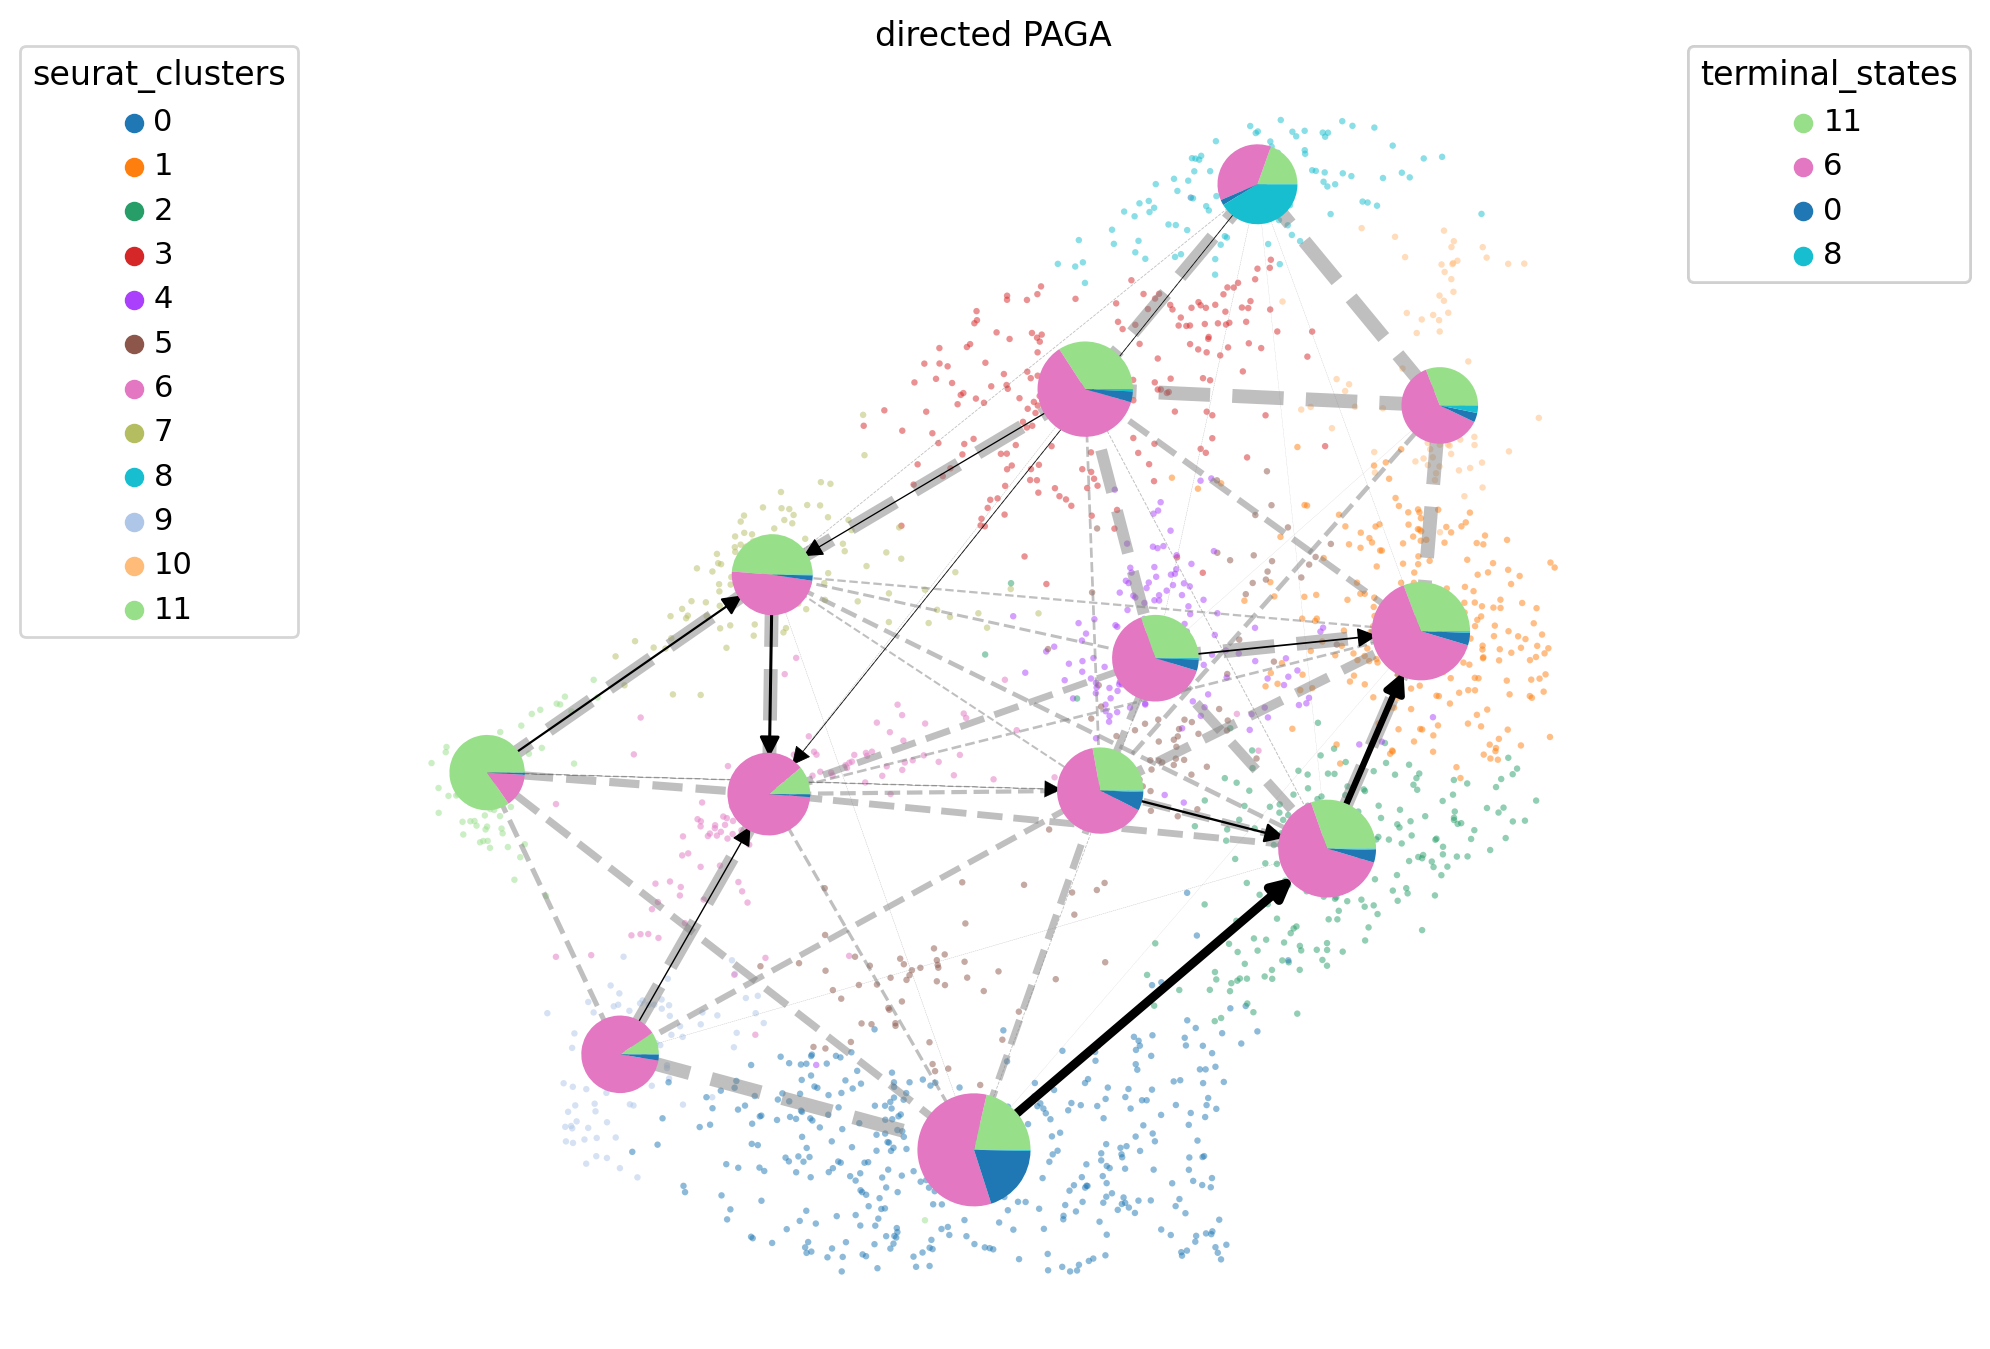

In [35]:
cr.pl.cluster_fates(
    adata,
    mode="paga_pie",
    cluster_key="seurat_clusters",
    basis="umap",
    legend_kwargs={"loc": "top right out"},
    legend_loc="top left out",
    node_size_scale=5,
    edge_width_scale=1,
    max_edge_width=5,
    title="directed PAGA",
)

### Lineage drivers

In [38]:
df = cr.tl.lineage_drivers(adata)
df.to_csv("../results/06_lineage_drivers.csv")
df

/projects/dan1/people/fdb589/envs/cellrank-1.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `cellrank.tl.lineage_drivers` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  """Entry point for launching an IPython kernel.


11_corr        11_pval        11_qval  11_ci_low  11_ci_high  \
ARX      0.570605  8.719187e-167  1.743837e-163   0.538648    0.600923   
SLC30A8  0.531590  1.579241e-139  1.579241e-136   0.497657    0.563897   
GCG      0.511109  8.908982e-127  5.939321e-124   0.476200    0.544409   
CHST9    0.438037   1.725943e-88   8.629717e-86   0.399982    0.474584   
PLPPR5   0.391436   5.657883e-69   1.616538e-66   0.351648    0.429812   
...           ...            ...            ...        ...         ...   
CDCA7L  -0.324130   3.177173e-46   3.530192e-44  -0.364813   -0.282212   
ZFP36L2 -0.333003   6.809444e-49   8.011110e-47  -0.373405   -0.291341   
SPTBN1  -0.347972   1.296504e-53   1.994622e-51  -0.387883   -0.306759   
PCBD1   -0.392383   2.448932e-69   8.163107e-67  -0.430723   -0.352628   
SGPL1   -0.422771   1.014832e-81   4.059330e-79  -0.459938   -0.384125   

           6_corr        6_pval        6_qval  6_ci_low  6_ci_high    0_corr  \
ARX     -0.365201  2.127464e-59  2.127464e-56 -0.404523  -0.324531 -0.172997   
SLC30A8 -0.360944  6.210497e-58  3.105248e-55 -0.400414  -0.320137 -0.088659   
GCG     -0.363749  6.763546e-59  4.509031e-56 -0.403122  -0.323032 -0.077272   
CHST9   -0.272062  2.221231e-32  2.961641e-30 -0.314256  -0.228796 -0.088970   
PLPPR5  -0.222196  8.623181e-22  3.449272e-20 -0.265611  -0.177881 -0.110512   
...           ...           ...           ...       ...        ...       ...   
CDCA7L   0.236830  1.208509e-24  6.905767e-23  0.192798   0.279910  0.153469   
ZFP36L2  0.182887  4.098959e-15  9.759427e-14  0.137912   0.227109  0.072057   
SPTBN1   0.200177  7.065892e-18  2.078203e-16  0.155475   0.244062  0.237506   
PCBD1    0.227742  7.555755e-23  3.434434e-21  0.183533   0.271033  0.256041   
SGPL1    0.242861  7.015549e-26  5.011106e-24  0.198952   0.285797  0.275775   

               0_pval        0_qval  0_ci_low  0_ci_high    8_corr    8_pval  \
ARX      1.186234e-13  1.371368e-12 -0.217400  -0.127879 -0.001322  0.955241   
SLC30A8  1.609854e-04  5.560808e-04 -0.134248  -0.042695 -0.047110  0.045358   
GCG      1.013480e-03  2.916490e-03 -0.122972  -0.031245 -0.029399  0.211900   
CHST9    1.526077e-04  5.280545e-04 -0.134556  -0.043008 -0.058944  0.012242   
PLPPR5   2.471552e-06  1.165826e-05 -0.155856  -0.064703 -0.050556  0.031718   
...               ...           ...       ...        ...       ...       ...   
CDCA7L   5.145852e-11  4.594510e-10  0.108096   0.198204 -0.099668  0.000022   
ZFP36L2  2.183066e-03  5.844889e-03  0.026005   0.117804  0.074900  0.001445   
SPTBN1   8.818822e-25  3.149579e-23  0.193488   0.280570 -0.104734  0.000008   
PCBD1    1.045846e-28  5.504454e-27  0.212412   0.298651 -0.108696  0.000004   
SGPL1    2.867564e-33  2.389637e-31  0.232596   0.317869 -0.113361  0.000001   

           8_qval  8_ci_low  8_ci_high  
ARX      0.964168 -0.047458   0.044819  
SLC30A8  0.074786 -0.093047  -0.000974  
GCG      0.285196 -0.075435   0.016762  
CHST9    0.023034 -0.104798  -0.012841  
PLPPR5   0.054191 -0.096470  -0.004428  
...           ...       ...        ...  
CDCA7L   0.000068 -0.145139  -0.053777  
ZFP36L2  0.003229  0.028862   0.120622  
SPTBN1   0.000026 -0.150147  -0.058880  
PCBD1    0.000012 -0.154062  -0.062873  
SGPL1    0.000005 -0.158669  -0.067576  

[2000 rows x 20 columns]

### Fate choices of cells ending up in specific HTO

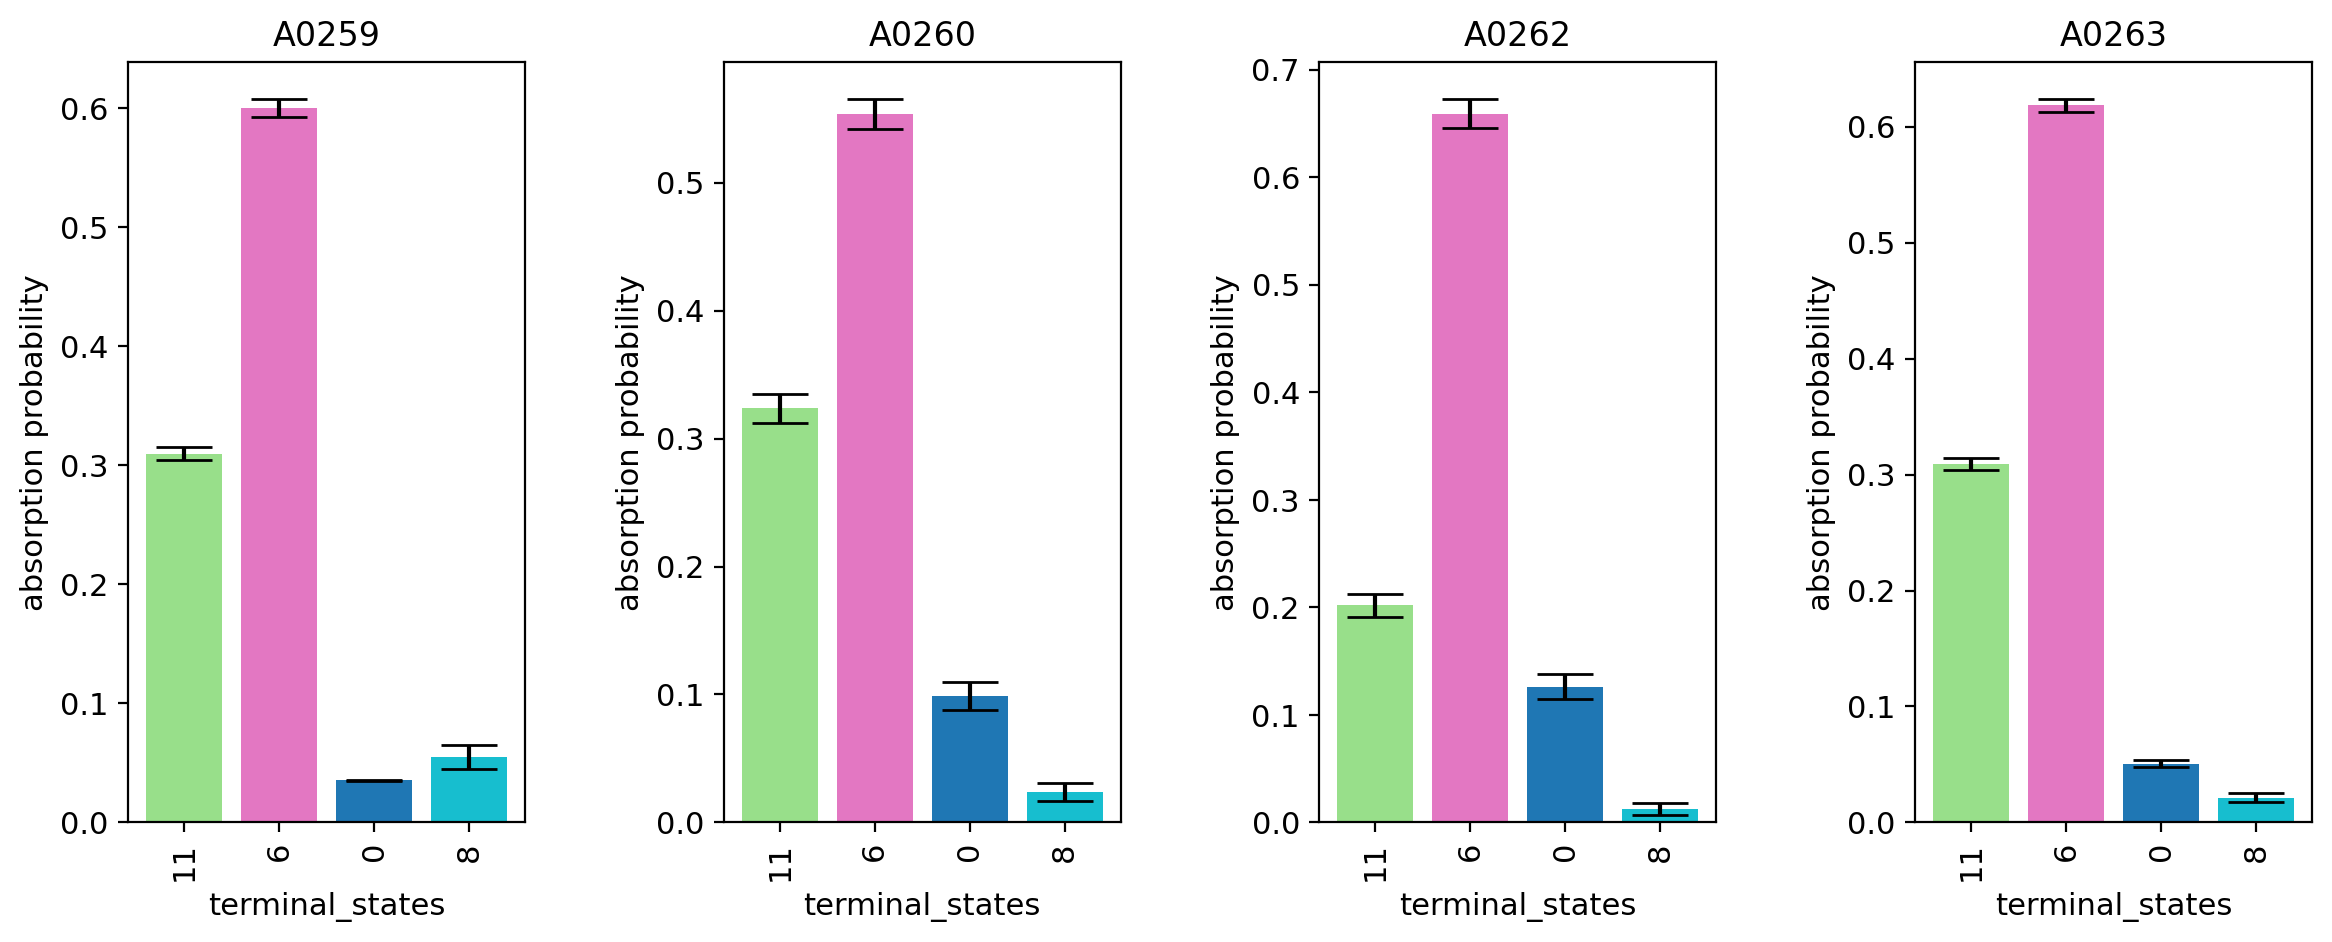

In [40]:
cr.pl.cluster_fates(adata, mode="bar", cluster_key="HTO_classification")

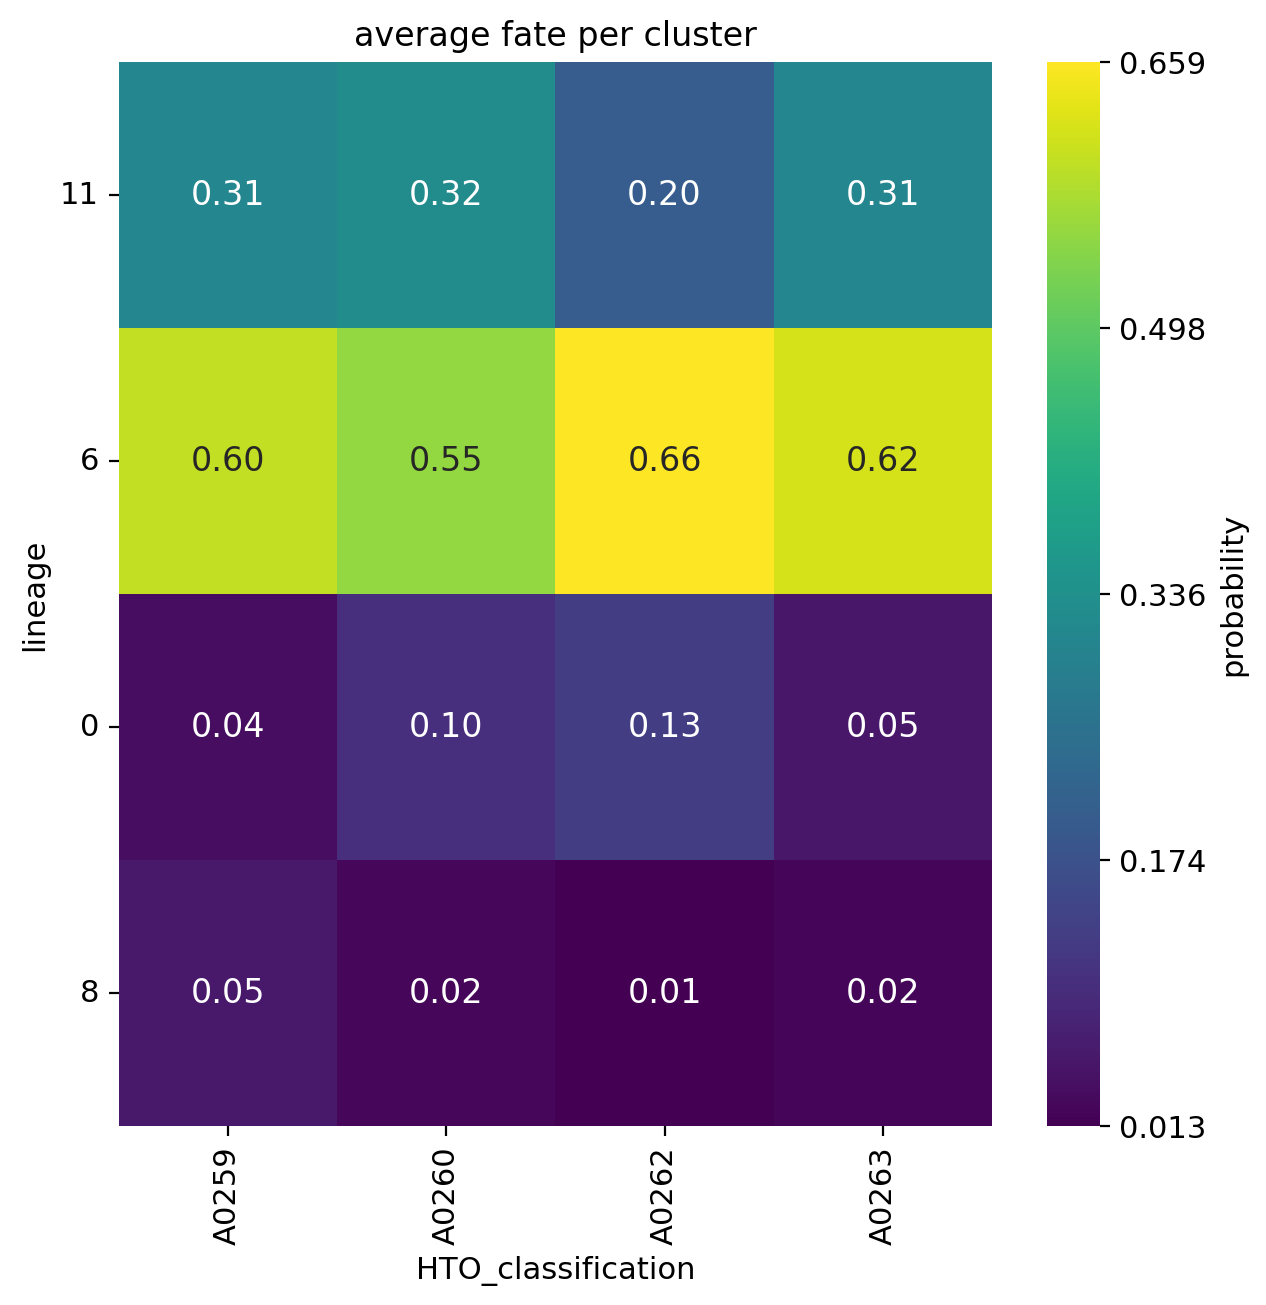

In [41]:
cr.pl.cluster_fates(adata, mode="heatmap", cluster_key="HTO_classification")

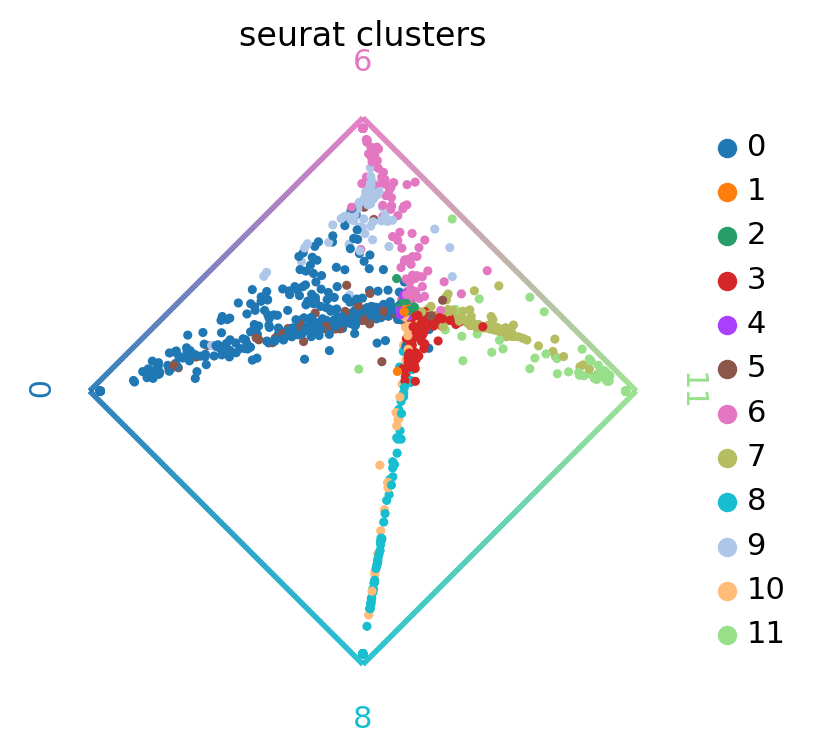

In [42]:
cr.pl.circular_projection(adata, keys="seurat_clusters", legend_loc="right")

## Save session

In [45]:
# adata.write("../data/processed/06_adata_cellrank.h5ad")

In [48]:
!jupyter nbconvert --to html 06_cellrank_subclsuter.ipynb --output-dir="../reports"

[NbConvertApp] Converting notebook 06_cellrank_subclsuter.ipynb to html
[NbConvertApp] Writing 6456678 bytes to ../reports/06_cellrank_subclsuter.html
